# Bonus-Track Assignment 2: Sequential MNIST classification task
Note: as a reference for keras tuner I used the documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [45]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
import keras_tuner as kt
from keras.datasets import mnist
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import pandas as pd

## Load the dataset

In [24]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()


print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


Plot the first digits

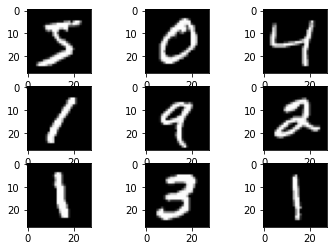

[5 0 4 1 9 2 1 3 1 4]


In [25]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

print(train_y[:10])

In [26]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoder.fit(test_y)

encoded__train_Y = encoder.transform(train_y)
encoded__test_Y = encoder.transform(test_y)

# convert integers to one hot encoded
y_train = np_utils.to_categorical(encoded__train_Y)
y_test = np_utils.to_categorical(encoded__test_Y)


flatten the input images into vectors

784


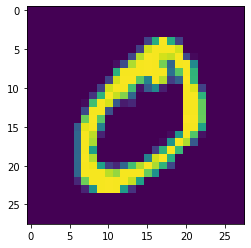

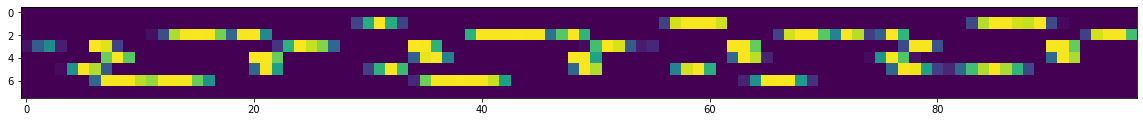

In [27]:
x_train = train_X.reshape(train_X.shape[0], -1)
x_test = test_X.reshape(test_X.shape[0], -1)
print(x_train.shape[1])

n = 1
x = train_X[n]
plt.imshow(x)
plt.show()
plt.figure(figsize = (20,15))
xx = (x_train[n]).reshape(8, int(len(x_train[n])/8))
plt.imshow(xx)




In [28]:
#reshape the data to feed the RNN
X_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
Y_train = np.reshape(y_train, (y_train.shape[0],1,y_train.shape[1]))
Y_train = y_train
X_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
Y_test = np.reshape(y_test, (y_test.shape[0],1,y_test.shape[1]))
Y_test = y_test
#check the shapes
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(60000, 784, 1)
(60000, 10)
(10000, 784, 1)
(10000, 10)


### Create the model
To do model selection, we actually create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [29]:
bs = 500 #batch size

In [30]:
def model_architecture(lr, hidden_units, activation_h):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation_h, input_shape=(bs,784,1), stateful = True, batch_input_shape=(bs,784,1))) 
    model.add(Dense(units=10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])
    return model

def create_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 50-120
    hidden_units = hp.Int('units',  min_value=50, max_value=120, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # call model-building code with the hyperparameter values.
    model = model_architecture( hidden_units = hidden_units, activation_h = activation_h, lr=lr
    )
    return model

Instantiate hyperparameter tuner

In [31]:
# use random search to find optimal hyperparameters
tuner = kt.RandomSearch(
                     hypermodel=create_model,
                     objective='val_accuracy',
                     max_trials=20,
                     #overwrite=True,
                     directory='tuner',
                     project_name='tuner_rnn'
                     )

tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Create a callback to stop training early after reaching a certain value for the validation loss.

In [32]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Train the model

In [33]:
tuner.search(X_train, Y_train, epochs=20, batch_size = bs, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
""")


Trial 20 Complete [00h 05m 58s]
val_accuracy: 0.3930000066757202

Best val_accuracy So Far: 0.49416667222976685
Total elapsed time: 02h 04m 18s
INFO:tensorflow:Oracle triggered exit

Completed hyperparameters search.

Otimal number of units of hidden layer = 70 

Optimal learning rate for the optimizer = 0.0001 

Optimal activation function for the hidden layer = tanh 




Find the optimal number of epochs

In [34]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(X_train, Y_train, epochs=100, batch_size = bs, verbose=2, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (500, 70)                 5040      
                                                                 
 dense_1 (Dense)             (500, 10)                 710       
                                                                 
Total params: 5,750
Trainable params: 5,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
96/96 - 37s - loss: 2.2112 - accuracy: 0.1912 - val_loss: 2.1199 - val_accuracy: 0.2362 - 37s/epoch - 389ms/step
Epoch 2/100
96/96 - 36s - loss: 2.0313 - accuracy: 0.2666 - val_loss: 1.9304 - val_accuracy: 0.2953 - 36s/epoch - 374ms/step
Epoch 3/100
96/96 - 36s - loss: 1.8853 - accuracy: 0.2891 - val_loss: 1.8246 - val_accuracy: 0.3067 - 36s/epoch - 376ms/step
Epoch 4/100
96/96 - 36s - loss: 1.8200 - accuracy: 0.3132 - val_loss: 1.7

Find best epoch:

In [35]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 99


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

In [54]:
# Retrain the model
history = hypermodel.fit(X_train, Y_train,batch_size = bs, epochs=best_epoch, verbose=2, validation_split = 0.2).history

Epoch 1/99
96/96 - 44s - loss: 1.4386 - accuracy: 0.4633 - val_loss: 1.3954 - val_accuracy: 0.4735 - 44s/epoch - 462ms/step
Epoch 2/99
96/96 - 48s - loss: 1.4285 - accuracy: 0.4656 - val_loss: 1.3938 - val_accuracy: 0.4735 - 48s/epoch - 504ms/step
Epoch 3/99
96/96 - 48s - loss: 1.4308 - accuracy: 0.4649 - val_loss: 1.3978 - val_accuracy: 0.4739 - 48s/epoch - 505ms/step
Epoch 4/99
96/96 - 49s - loss: 1.4220 - accuracy: 0.4672 - val_loss: 1.3911 - val_accuracy: 0.4755 - 49s/epoch - 508ms/step
Epoch 5/99
96/96 - 48s - loss: 1.4229 - accuracy: 0.4667 - val_loss: 1.4312 - val_accuracy: 0.4513 - 48s/epoch - 503ms/step
Epoch 6/99
96/96 - 59s - loss: 1.4338 - accuracy: 0.4632 - val_loss: 1.3950 - val_accuracy: 0.4737 - 59s/epoch - 610ms/step
Epoch 7/99
96/96 - 51s - loss: 1.4211 - accuracy: 0.4678 - val_loss: 1.4070 - val_accuracy: 0.4685 - 51s/epoch - 536ms/step
Epoch 8/99
96/96 - 54s - loss: 1.4209 - accuracy: 0.4663 - val_loss: 1.3932 - val_accuracy: 0.4765 - 54s/epoch - 564ms/step
Epoch 9/

Save history data

In [55]:
hist_df = pd.DataFrame(history) 
# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

To load the history data use:

In [56]:
#history = pd.read_json('history.json')

### Make plots of the loss and validation loss

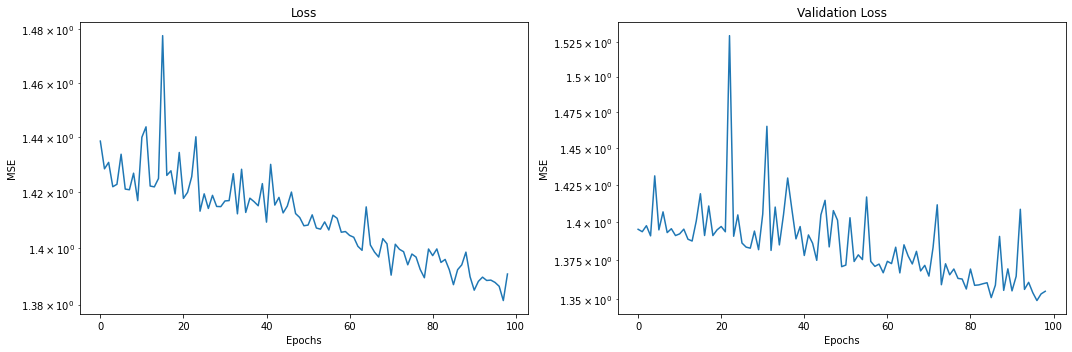

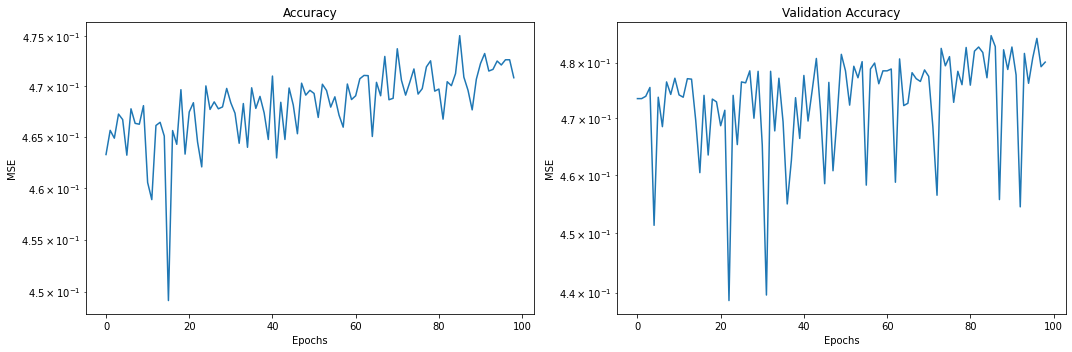

In [57]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.title('Validation Loss')
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.savefig("plots/RNN_loss.pdf")


plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Accuracy')
plt.plot(history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.title('Validation Accuracy')
plt.plot(history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.savefig("plots/RNN_loss.pdf")

plt.show()

Save the model

In [58]:
hypermodel.save('keras_model_rnn')

INFO:tensorflow:Assets written to: keras_model_rnn/assets


INFO:tensorflow:Assets written to: keras_model_rnn/assets


Command to (eventually) load the saved model:

In [59]:
#hypermodel = keras.models.load_model('keras_model_rnn')

### Evaluate the model

In [60]:
scores = model.evaluate(X_test, Y_test,batch_size = bs, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 50.37%
